In [11]:
import csv
from collections import defaultdict
from pathlib import Path

csv_file_path = Path("attributes.csv")

subset_counts_0 = defaultdict(int)
subset_counts_1 = defaultdict(int)
subset_counts_other = defaultdict(int)
subset_total = 0

with open(csv_file_path, "r", encoding="utf-8", newline="") as f:
    reader = csv.DictReader(f)
    subset_attrs = [c for c in reader.fieldnames if c != "image_id"]
    print(f"Number of attributes: {len(subset_attrs)}")

    for row in reader:
        subset_total += 1
        for a in subset_attrs:
            v = row[a].strip()
            if v == "1":
                subset_counts_1[a] += 1
            elif v == "0":
                subset_counts_0[a] += 1
            else:
                subset_counts_other[a] += 1

print(f"Number of examples: {subset_total}")

subset_rows = []
subset_frac1 = {}
for a in subset_attrs:
    c0 = subset_counts_0[a]
    c1 = subset_counts_1[a]
    co = subset_counts_other[a]
    denom = c0 + c1 + co
    frac1 = (c1 / denom) if denom else 0.0
    subset_rows.append((a, c0, c1, co, frac1))
    subset_frac1[a] = frac1

subset_rows.sort(key=lambda x: x[-1], reverse=True)

out_path = Path("attribute_stats_subset.txt")
with open(out_path, "w", encoding="utf-8") as f:
    f.write(f"Number of attributes: {len(subset_attrs)}\n")
    f.write(f"Number of examples: {subset_total}\n\n")
    f.write("Attribute distribution (sorted by fraction of 1s):\n")
    f.write(f"{'attr':<22} {'count_0':>8} {'count_1':>8} {'other':>8} {'frac_1':>8}\n")
    f.write("-" * 60 + "\n")
    for a, c0, c1, co, frac1 in subset_rows:
        f.write(f"{a:<22} {c0:>8d} {c1:>8d} {co:>8d} {frac1:>8.4f}\n")

print(f"Saved full subset table to: {out_path}")

print("\nTop 10 by frac_1:")
for a, c0, c1, co, frac1 in subset_rows[:10]:
    print(f"{a:<22} {c0:>8d} {c1:>8d} {co:>8d} {frac1:>8.4f}")

print("\nBottom 10 by frac_1:")
for a, c0, c1, co, frac1 in subset_rows[-10:]:
    print(f"{a:<22} {c0:>8d} {c1:>8d} {co:>8d} {frac1:>8.4f}")

hi = [a for a, *_rest, frac1 in subset_rows if frac1 >= 0.95]
lo = [a for a, *_rest, frac1 in subset_rows if frac1 <= 0.05]

print("\nCandidates for filtering (near-constant attributes in subset):")
print(f"frac_1 >= 0.95 ({len(hi)}): {hi}")
print(f"frac_1 <= 0.05 ({len(lo)}): {lo}")

Number of attributes: 40
Number of examples: 63715
Saved full subset table to: attribute_stats_subset.txt

Top 10 by frac_1:
No_Beard                      0    63715        0   1.0000
Young                     16634    47081        0   0.7389
Male                      28385    35330        0   0.5545
Mouth_Slightly_Open       34817    28898        0   0.4536
Smiling                   35414    28301        0   0.4442
High_Cheekbones           37749    25966        0   0.4075
Attractive                38548    25167        0   0.3950
Bags_Under_Eyes           43658    20057        0   0.3148
Straight_Hair             46373    17342        0   0.2722
Big_Nose                  46627    17088        0   0.2682

Bottom 10 by frac_1:
Pale_Skin                 60674     3041        0   0.0477
Bald                      62149     1566        0   0.0246
Rosy_Cheeks               63151      564        0   0.0089
Goatee                    63556      159        0   0.0025
Mustache                  6

In [12]:
from pathlib import Path

orig_path = Path("celeba_anno/list_attr_celeba.txt")

full_counts_pos = {a: 0 for a in subset_attrs}
full_counts_neg = {a: 0 for a in subset_attrs}
full_total = 0

YES = {"1", "yes", "Yes", "TRUE", "True"}
NO = {"-1", "no", "No", "FALSE", "False", "0"}

with open(orig_path, "r", encoding="utf-8") as f:
    first_line = ""
    for line in f:
        line = line.strip()
        if line:
            first_line = line
            break

    if not first_line:
        raise RuntimeError(f"Empty file: {orig_path}")

    toks = first_line.split()

    expected_total = None
    header = None

    # Format A (common in official CelebA):
    #   line1: <num_images>
    #   line2: <40 attribute names>
    #   rest : <img> <40 values>
    if len(toks) == 1 and toks[0].isdigit():
        expected_total = int(toks[0])
        header = f.readline().strip().split()
    # Format B (your file):
    #   line1: <num_images> <40 attribute names>
    #   rest : <img> <40 values>
    elif toks[0].isdigit() and len(toks) >= 2:
        expected_total = int(toks[0])
        header = toks[1:]
    # Format C:
    #   line1: <40 attribute names>
    else:
        header = toks

    name_to_idx = {name: i for i, name in enumerate(header)}

    for line in f:
        parts = line.strip().split()
        if len(parts) < 1 + len(header):
            continue
        vals = parts[1 : 1 + len(header)]

        full_total += 1
        for a in subset_attrs:
            i = name_to_idx.get(a)
            if i is None:
                continue
            v = vals[i]
            if v in YES:
                full_counts_pos[a] += 1
            elif v in NO:
                full_counts_neg[a] += 1

if expected_total is not None and expected_total != full_total:
    print(f"Note: expected_total={expected_total} but parsed_total={full_total}")

full_rows = []
full_frac1 = {}
for a in subset_attrs:
    c1 = full_counts_pos[a]
    c0 = full_counts_neg[a]
    denom = c0 + c1
    frac1 = (c1 / denom) if denom else 0.0
    full_rows.append((a, c0, c1, 0, frac1))
    full_frac1[a] = frac1

full_rows.sort(key=lambda x: x[-1], reverse=True)

out_path = Path("attribute_stats_full_celeba.txt")
with open(out_path, "w", encoding="utf-8") as f:
    f.write(f"Source: {orig_path}\n")
    f.write(f"Number of attributes: {len(subset_attrs)}\n")
    f.write(f"Number of examples parsed: {full_total}\n\n")
    f.write("Attribute distribution (sorted by fraction of 1s):\n")
    f.write(f"{'attr':<22} {'count_0':>8} {'count_1':>8} {'other':>8} {'frac_1':>8}\n")
    f.write("-" * 60 + "\n")
    for a, c0, c1, co, frac1 in full_rows:
        f.write(f"{a:<22} {c0:>8d} {c1:>8d} {co:>8d} {frac1:>8.6f}\n")

print(f"Saved full CelebA table to: {out_path}")

diffs = []
for a in subset_attrs:
    d = subset_frac1[a] - full_frac1[a]
    diffs.append((a, subset_frac1[a], full_frac1[a], d, abs(d)))

diffs.sort(key=lambda x: x[-1], reverse=True)

out_path = Path("attribute_shift_all.txt")
with open(out_path, "w", encoding="utf-8") as f:
    f.write(f"{'attr':<22} {'subset':>10} {'full':>10} {'diff':>10}\n")
    f.write("-" * 70 + "\n")
    for a, s, f1, d, _ad in diffs:
        f.write(f"{a:<22} {s:>10.6f} {f1:>10.6f} {d:>10.6f}\n")

print(f"Saved full shift table to: {out_path}")

Saved full CelebA table to: attribute_stats_full_celeba.txt
Saved full shift table to: attribute_shift_all.txt


Saved grid: /Users/yiwu/Documents/Github/modal/cmu-10799-diffusion/data/celeba-subset/train/subset_grid.png


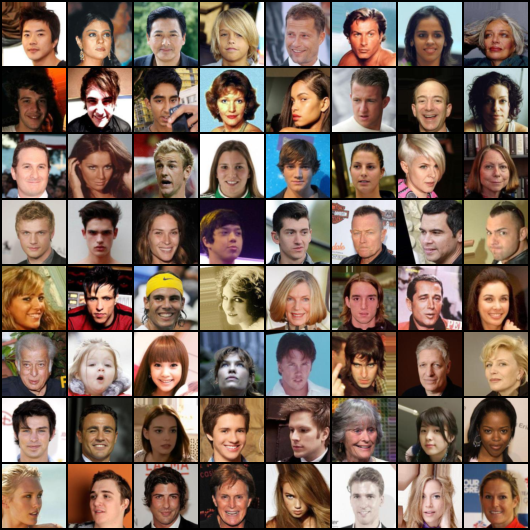

In [13]:
import sys
import random
from pathlib import Path

import torch
from PIL import Image
from torchvision import transforms

# Find repo root (directory that contains 'src/')
repo_root = Path.cwd().resolve()
while not (repo_root / "src").exists() and repo_root != repo_root.parent:
    repo_root = repo_root.parent

if not (repo_root / "src").exists():
    raise RuntimeError("Could not find repo root containing 'src/'")

sys.path.insert(0, str(repo_root))

from src.data.celeba import make_grid, save_image  # uses torchvision under the hood

images_dir = Path.cwd() / "images"
assert images_dir.exists(), f"Missing images dir: {images_dir}"

# Sample images
num = 64
paths = sorted(images_dir.glob("*.png"))
if len(paths) == 0:
    paths = sorted(images_dir.glob("*.jpg"))

if len(paths) < num:
    num = len(paths)

sample_paths = random.sample(paths, num)

to_tensor = transforms.ToTensor()  # [0,1]
imgs = [to_tensor(Image.open(p).convert("RGB")) for p in sample_paths]
batch = torch.stack(imgs, dim=0)

grid = make_grid(batch, nrow=8)

out_path = Path.cwd() / "subset_grid.png"
# save_image expects a batch; wrap grid to keep it simple
save_image(grid.unsqueeze(0), str(out_path), nrow=1)

print("Saved grid:", out_path)

# Display
Image.open(out_path)